<a href="https://colab.research.google.com/github/farrelrassya/teachingMLDL/blob/main/02.%20Deep%20Learning/07.%20Week%207/Notebooks/01-Bi_RNN_and_BayesianOptimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import library yang dibutuhkan
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

# Cek versi TensorFlow
print("TensorFlow version:", tf.__version__)

# Muat dataset AG News melalui TFDS
dataset_name = "ag_news_subset"
data, info = tfds.load(dataset_name, with_info=True, as_supervised=True)
train_ds, test_ds = data['train'], data['test']

# Tentukan jumlah data train dan test
num_train = info.splits['train'].num_examples
num_test = info.splits['test'].num_examples
print(f"Jumlah sampel train: {num_train}, sampel test: {num_test}")

TensorFlow version: 2.18.0


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.24ZITZ_1.0.0/ag_news_subset-train.tfrecord*...: …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.24ZITZ_1.0.0/ag_news_subset-test.tfrecord*...:  …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.
Jumlah sampel train: 120000, sampel test: 7600


In [2]:
# Membagi train dataset menjadi train dan validation (90% train, 10% val)
train_split = 0.9
train_ds = tfds.load(dataset_name, split=f"train[:{int(train_split*100)}%]", as_supervised=True)
val_ds   = tfds.load(dataset_name, split=f"train[{int(train_split*100)}%:]", as_supervised=True)

# Verifikasi ukuran setelah split
count_train = 0
for _ in train_ds: count_train += 1
count_val = 0
for _ in val_ds: count_val += 1
print(f"Split train menjadi -> train: {count_train} sampel, validation: {count_val} sampel")

Split train menjadi -> train: 108000 sampel, validation: 12000 sampel


In [3]:
# Menampilkan 1 contoh data dari train_ds
for text, label in train_ds.take(1):
    print("Contoh teks:\n", text.numpy()[:100], "...")  # tampilkan 100 karakter pertama
    print("Label kategori:", label.numpy())

Contoh teks:
 b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, includ' ...
Label kategori: 3


In [4]:
import re

# Konversi tf.data.Dataset menjadi list of strings dan list of labels
train_texts = []
train_labels = []
for text, label in train_ds:
    # decoding bytes ke string
    s = text.numpy().decode('utf-8')
    train_texts.append(s)
    train_labels.append(int(label.numpy()))

val_texts = []
val_labels = []
for text, label in val_ds:
    val_texts.append(text.numpy().decode('utf-8'))
    val_labels.append(int(label.numpy()))

test_texts = []
test_labels = []
for text, label in test_ds:
    test_texts.append(text.numpy().decode('utf-8'))
    test_labels.append(int(label.numpy()))

print("Jumlah data (train/val/test):", len(train_texts), len(val_texts), len(test_texts))

# Contoh teks sebelum cleaning
print("\nContoh sebelum cleaning:")
print(train_texts[0][:200], "...")

Jumlah data (train/val/test): 108000 12000 7600

Contoh sebelum cleaning:
AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions. ...


In [5]:
# Fungsi sederhana untuk cleaning teks: lowercasing & hapus non-huruf
def clean_text(text):
    # lowercasing
    text = text.lower()
    # hapus karakter yang bukan huruf atau angka (boleh modifikasi sesuai kebutuhan)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Terapkan cleaning ke dataset
train_texts_clean = [clean_text(t) for t in train_texts]
val_texts_clean = [clean_text(t) for t in val_texts]
test_texts_clean = [clean_text(t) for t in test_texts]

print("Contoh setelah cleaning:")
print(train_texts[0][:100], "\n--> menjadi:\n", train_texts_clean[0][:100], "...")

Contoh setelah cleaning:
AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, includ 
--> menjadi:
 amd 39 s new dual core opteron chip is designed mainly for corporate computing applications includin ...


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tentukan ukuran vocabulary dan panjang maksimum
vocab_size = 20000  # batasi kata paling sering
max_len = 100       # panjang maksimum sequence (kata)

# Inisialisasi dan fit tokenizer pada teks training
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts_clean)

# Konversi teks menjadi sequence of integers
X_train_seq = tokenizer.texts_to_sequences(train_texts_clean)
X_val_seq = tokenizer.texts_to_sequences(val_texts_clean)
X_test_seq = tokenizer.texts_to_sequences(test_texts_clean)

# Lakukan padding agar semua sequence memiliki panjang max_len
X_train = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val   = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')
X_test  = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Konversi label ke numpy array
y_train = np.array(train_labels)
y_val   = np.array(val_labels)
y_test  = np.array(test_labels)

print("Contoh sequence (sebelum padding):", X_train_seq[0][:10])
print("Contoh sequence (setelah padding):", X_train[0][:15])
print("Panjang sequence setelah padding:", X_train.shape[1])
print("Ukuran vocab (jumlah kata unik di training):", len(tokenizer.word_index))

Contoh sequence (sebelum padding): [1489, 11, 8, 22, 2442, 1685, 5163, 635, 18, 803]
Contoh sequence (setelah padding): [1489   11    8   22 2442 1685 5163  635   18  803 4676   10  716 1788
  989]
Panjang sequence setelah padding: 100
Ukuran vocab (jumlah kata unik di training): 58487


In [7]:
# Definisikan parameter model
embedding_dim = 128
lstm_units = 64

# Bangun arsitektur model BiLSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=False)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Tampilkan ringkasan arsitektur model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Tentukan epochs dan batch size
epochs = 5
batch_size = 128

# Latih model
history = model.fit(X_train, y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val))

Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.7587 - loss: 0.6200 - val_accuracy: 0.9085 - val_loss: 0.2748
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9301 - loss: 0.2234 - val_accuracy: 0.9108 - val_loss: 0.2682
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9447 - loss: 0.1695 - val_accuracy: 0.9073 - val_loss: 0.2886
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9569 - loss: 0.1281 - val_accuracy: 0.9028 - val_loss: 0.3423
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9664 - loss: 0.0954 - val_accuracy: 0.9018 - val_loss: 0.3495


In [9]:
# Evaluasi model pada data test
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=0)
print(f"Akurasi pada data uji: {acc_test:.4f}, Loss pada data uji: {loss_test:.4f}")

Akurasi pada data uji: 0.9087, Loss pada data uji: 0.3423


In [10]:
from sklearn.metrics import confusion_matrix, classification_report

# Prediksi kelas untuk data test
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Tampilkan laporan klasifikasi (precision, recall, f1 per kelas)
print("\nClassification Report:")
target_names = ["World", "Sports", "Business", "Sci/Tech"]
print(classification_report(y_test, y_pred, target_names=target_names))

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Confusion Matrix:
[[1681   49   81   89]
 [  21 1836   18   25]
 [  46   14 1638  202]
 [  42   12   95 1751]]

Classification Report:
              precision    recall  f1-score   support

       World       0.94      0.88      0.91      1900
      Sports       0.96      0.97      0.96      1900
    Business       0.89      0.86      0.88      1900
    Sci/Tech       0.85      0.92      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



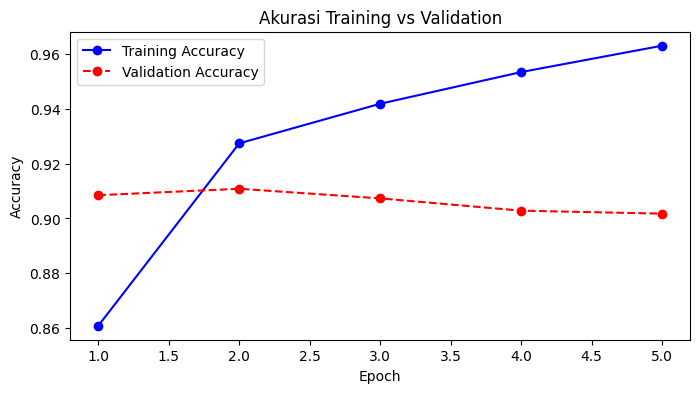

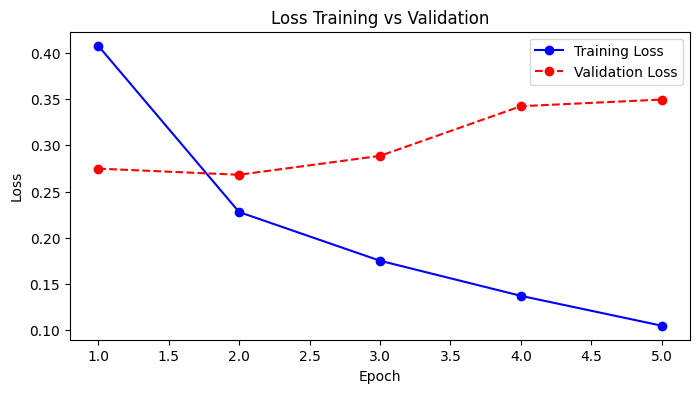

In [11]:
import matplotlib.pyplot as plt

# Ambil nilai metrik dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc)+1)

# Plot akurasi training vs validation
plt.figure(figsize=(8,4))
plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'ro--', label='Validation Accuracy')
plt.title('Akurasi Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss training vs validation
plt.figure(figsize=(8,4))
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro--', label='Validation Loss')
plt.title('Loss Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.5 MB/s eta 0:00:00


In [13]:
# Jika belum terinstal, uncomment baris di bawah ini
# !pip install keras-tuner

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras_tuner as kt
import numpy as np

# Asumsikan X_train, y_train, X_val, y_val telah disiapkan dari langkah preprocessing sebelumnya.
# Jika belum, pastikan untuk menjalankan bagian preprocessing dari notebook sebelumnya.

# Misalnya, untuk keperluan demonstrasi, kita asumsikan variabel berikut sudah ada:
# X_train, y_train, X_val, y_val

# Fungsi untuk membangun model dengan hyperparameter tuning
def build_model(hp):
    model = tf.keras.Sequential()

    # Hyperparameter: embedding dimension
    embedding_dim = hp.Choice('embedding_dim', values=[64, 128, 200])
    model.add(tf.keras.layers.Embedding(input_dim=20000,  # vocab_size, disesuaikan dengan kode sebelumnya
                                        output_dim=embedding_dim,
                                        input_length=100))  # max_len, disesuaikan

    # Hyperparameter: jumlah unit LSTM
    lstm_units = hp.Choice('lstm_units', values=[32, 64, 128])
    model.add(tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(lstm_units, return_sequences=False)
    ))

    # Hyperparameter: jumlah unit di Dense layer
    dense_units = hp.Choice('dense_units', values=[32, 64, 128])
    model.add(tf.keras.layers.Dense(dense_units, activation='relu'))

    # Hyperparameter: dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # Layer output (4 kelas)
    model.add(tf.keras.layers.Dense(4, activation='softmax'))

    # Hyperparameter: learning rate
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

# Inisialisasi tuner dengan Bayesian Optimization
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Jumlah percobaan hyperparameter
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='BiRNN_Tuning'
)

# Tampilkan ringkasan ruang hyperparameter yang akan dituning
tuner.search_space_summary()

# Lakukan pencarian hyperparameter.
# Sesuaikan epoch dan batch size sesuai kebutuhan dan sumber daya.
tuner.search(X_train, y_train,
             epochs=5,
             batch_size=128,
             validation_data=(X_val, y_val))

# Tampilkan ringkasan hasil pencarian
tuner.results_summary()

# Ambil model terbaik berdasarkan metrik validasi
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Hyperparameter terbaik yang ditemukan:")
print(f"Embedding Dimension: {best_hp.get('embedding_dim')}")
print(f"LSTM Units: {best_hp.get('lstm_units')}")
print(f"Dense Units: {best_hp.get('dense_units')}")
print(f"Dropout Rate: {best_hp.get('dropout_rate')}")
print(f"Learning Rate: {best_hp.get('learning_rate')}")

Trial 10 Complete [00h 01m 41s]
val_accuracy: 0.8992499709129333

Best val_accuracy So Far: 0.9120000004768372
Total elapsed time: 00h 15m 53s
Results summary
Results in tuner_dir/BiRNN_Tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
embedding_dim: 64
lstm_units: 32
dense_units: 64
dropout_rate: 0.4
learning_rate: 0.0016187959221574872
Score: 0.9120000004768372

Trial 03 summary
Hyperparameters:
embedding_dim: 128
lstm_units: 128
dense_units: 128
dropout_rate: 0.6000000000000001
learning_rate: 0.0048296228317513835
Score: 0.9100000262260437

Trial 07 summary
Hyperparameters:
embedding_dim: 128
lstm_units: 32
dense_units: 64
dropout_rate: 0.5
learning_rate: 0.00036366032209611337
Score: 0.9100000262260437

Trial 05 summary
Hyperparameters:
embedding_dim: 128
lstm_units: 128
dense_units: 128
dropout_rate: 0.5
learning_rate: 0.004082687674516097
Score: 0.909333348274231

Trial 00 summary
Hyperparameters:
embedding_dim: 128
l

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [14]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Asumsi: X_train, y_train, X_val, y_val, dan X_test, y_test sudah didefinisikan
# dari preprocessing sebelumnya (tokenisasi, padding, dll).

# 1. Definisikan hyperparameter terbaik yang diperoleh dari tuning:
embedding_dim = 64
lstm_units    = 32
dense_units   = 64
dropout_rate  = 0.4
learning_rate = 0.0016187959221574872
vocab_size    = 20000  # Sesuaikan dengan nilai yang digunakan saat preprocessing
max_len       = 100    # Sesuaikan dengan nilai max_len yang dipakai

# 2. Bangun model BiRNN (Bidirectional LSTM) dengan hyperparameter terbaik:
model_best = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=False)),
    tf.keras.layers.Dense(dense_units, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 kelas untuk AG News
])

# Kompilasi model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_best.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Tampilkan ringkasan model
model_best.summary()

# 3. Retraining model terbaik menggunakan data full (train + validation)
# Menggabungkan data train dan validation
X_full = np.concatenate([X_train, X_val], axis=0)
y_full = np.concatenate([y_train, y_val], axis=0)

# Setup callback untuk early stopping dan penyimpanan model terbaik
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_birnn_model.h5', monitor='val_loss', save_best_only=True)
]

# Latih ulang model (retrain) dengan validation split 10%
history_full = model_best.fit(
    X_full, y_full,
    epochs=20,              # Bisa ditingkatkan jika diperlukan
    batch_size=128,
    validation_split=0.1,
    callbacks=callbacks
)

# 4. Evaluasi model pada data test
loss_test, acc_test = model_best.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss_test:.4f}, Test Accuracy: {acc_test:.4f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
840/844 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7749 - loss: 0.5818

844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7754 - loss: 0.5806 - val_accuracy: 0.9075 - val_loss: 0.2727
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9316 - loss: 0.2094 - val_accuracy: 0.9053 - val_loss: 0.2887
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9462 - loss: 0.1588 - val_accuracy: 0.9091 - val_loss: 0.2829
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9563 - loss: 0.1253 - val_accuracy: 0.9005 - val_loss: 0.3174
Test Loss: 0.2703, Test Accuracy: 0.9088


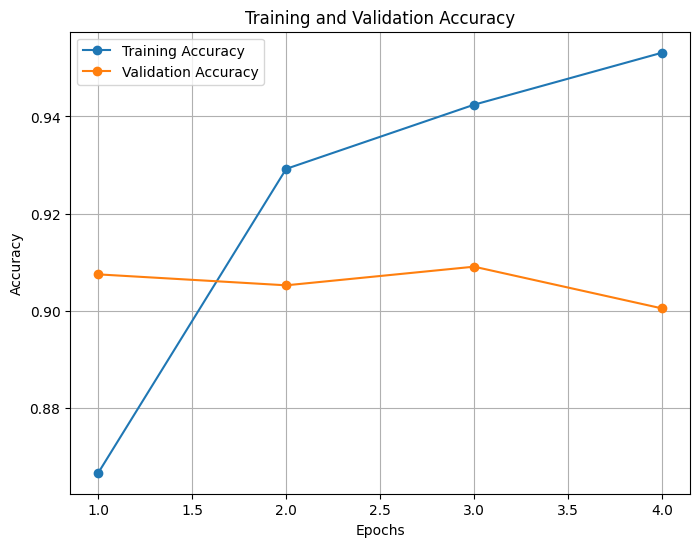

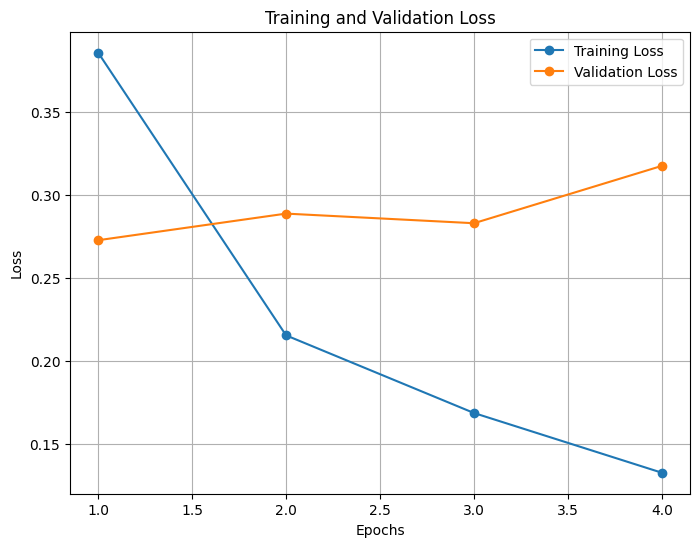

In [15]:
# Ekstrak metrik dari history retraining
acc = history_full.history['accuracy']
val_acc = history_full.history['val_accuracy']
loss = history_full.history['loss']
val_loss = history_full.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plot Akurasi Training vs Validation
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss Training vs Validation
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Confusion Matrix:
 [[1724   55   80   41]
 [  22 1850   14   14]
 [  74   14 1671  141]
 [  71   14  153 1662]]


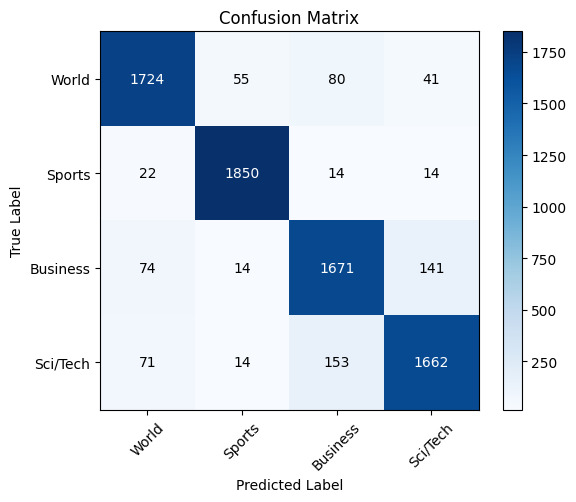


Classification Report:
              precision    recall  f1-score   support

       World       0.91      0.91      0.91      1900
      Sports       0.96      0.97      0.97      1900
    Business       0.87      0.88      0.88      1900
    Sci/Tech       0.89      0.87      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



In [16]:
# Prediksi model pada data uji
y_pred_prob = model_best.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Visualisasi Confusion Matrix dengan Matplotlib
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Label untuk kelas (sesuaikan dengan urutan kelas)
class_names = ["World", "Sports", "Business", "Sci/Tech"]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Tambahkan nilai di tiap sel confusion matrix
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Tampilkan juga classification report untuk informasi lebih lengkap
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

In [17]:
import tensorflow as tf
import keras_tuner as kt

def build_model(hp):
    model = tf.keras.Sequential()

    # Layer Embedding
    embedding_dim = hp.Choice('embedding_dim', values=[64, 128, 200])
    model.add(tf.keras.layers.Embedding(input_dim=20000,  # vocab_size
                                        output_dim=embedding_dim,
                                        input_length=100))  # max_len

    # Bidirectional LSTM dengan L2 Regularization
    lstm_units = hp.Choice('lstm_units', values=[32, 64, 128])
    l2_lstm = hp.Float('l2_lstm', min_value=1e-4, max_value=1e-2, sampling='log')
    model.add(tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(lstm_units,
                             return_sequences=False,
                             kernel_regularizer=tf.keras.regularizers.l2(l2_lstm))
    ))

    # Opsional: Hidden Dense layer tambahan
    if hp.Boolean('use_extra_dense'):
        dense_units_extra = hp.Choice('dense_units_extra', values=[32, 64, 128])
        l2_dense_extra = hp.Float('l2_dense_extra', min_value=1e-4, max_value=1e-2, sampling='log')
        model.add(tf.keras.layers.Dense(dense_units_extra, activation='relu',
                                        kernel_regularizer=tf.keras.regularizers.l2(l2_dense_extra)))
        # Tambahkan Batch Normalization setelah Dense tambahan
        model.add(tf.keras.layers.BatchNormalization())
        # Dropout tambahan
        dropout_extra = hp.Float('dropout_extra', min_value=0.3, max_value=0.7, step=0.1)
        model.add(tf.keras.layers.Dropout(dropout_extra))

    # Dense layer utama dengan L2 regularisasi
    dense_units = hp.Choice('dense_units', values=[32, 64, 128])
    l2_dense = hp.Float('l2_dense', min_value=1e-4, max_value=1e-2, sampling='log')
    model.add(tf.keras.layers.Dense(dense_units, activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(l2_dense)))

    # Dropout layer
    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # Layer output untuk 4 kelas
    model.add(tf.keras.layers.Dense(4, activation='softmax'))

    # Optimizer dengan hyperparameter learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model

# Inisialisasi Bayesian Tuner dengan ruang hyperparameter baru
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # kamu bisa menambah jumlah trial untuk eksplorasi ruang yang lebih luas
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='BiRNN_Advanced_Tuning'
)

# Tampilkan ringkasan ruang pencarian hyperparameter
tuner.search_space_summary()

# Lakukan pencarian hyperparameter dengan data training dan validasi
# Pastikan X_train, y_train, X_val, y_val sudah didefinisikan dari tahap preprocessing
tuner.search(X_train, y_train,
             epochs=5,
             batch_size=128,
             validation_data=(X_val, y_val))

# Tampilkan ringkasan hasil pencarian
tuner.results_summary()

Trial 20 Complete [00h 01m 47s]
val_accuracy: 0.8921666741371155

Best val_accuracy So Far: 0.9099166393280029
Total elapsed time: 00h 33m 28s
Results summary
Results in tuner_dir/BiRNN_Advanced_Tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 03 summary
Hyperparameters:
embedding_dim: 200
lstm_units: 32
l2_lstm: 0.001035683592913583
use_extra_dense: False
dense_units: 128
l2_dense: 0.00010749029752863633
dropout_rate: 0.5
learning_rate: 0.000596718786458907
dense_units_extra: 64
l2_dense_extra: 0.002104606929369123
dropout_extra: 0.6000000000000001
Score: 0.9099166393280029

Trial 04 summary
Hyperparameters:
embedding_dim: 64
lstm_units: 64
l2_lstm: 0.0002487282764227902
use_extra_dense: False
dense_units: 128
l2_dense: 0.009592209502279035
dropout_rate: 0.5
learning_rate: 0.0009806077993409813
dense_units_extra: 32
l2_dense_extra: 0.00695461878420833
dropout_extra: 0.5
Score: 0.9089999794960022

Trial 17 summary
Hyperparameters:
embedding_dim: 200
